# IBSR_18:Brain Tissue Segmentation Using Deep Learning
Author(s): **Mohammad Imran Hossain, Muhammad Zain Amin**
<br>University of Girona, Spain
<br>Erasmus Mundus Joint Master Degree in Medical Imaging and Applications


# Necessary Libraries

In [1]:
# Import all the necessary libraries
import os
import cv2
import glob
import random
import tqdm 
import scipy.misc
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import SimpleITK as sitk
from pathlib import Path
from scipy import ndimage
from tabulate import tabulate
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Input

from scipy.spatial.distance import directed_hausdorff

import segmentation_models as sm


2024-01-12 20:24:48.047067: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-12 20:24:48.124319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 20:24:48.124364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 20:24:48.126042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 20:24:48.137064: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `keras` framework.


# Import Dataset
- **Load the train and validation dataset from the dirctory.**

In [2]:
# Define the path of the train and validation dataset directory
TRAIN_DATA_PATH = Path('/home/cad05/MISA/IBSR_18_BraTS_Deep_Learning/Dataset/Training_Set')
VALID_DATA_PATH = Path('/home/cad05/MISA/IBSR_18_BraTS_Deep_Learning/Dataset/Validation_Set')

# Define the path for saving the trained model
MODEL_SAVE_PATH = Path('/home/cad05/MISA/IBSR_18_BraTS_Deep_Learning/Models')

In [3]:
# Define a function to load image dataset from a directory
def load_data(image_size, data_path):
    """
    Load image and label data from a specified directory path.

    Args:
    - image_size : Image dimensions (slices, height, width).
    - data_path  : Path of the directory containing image and label data.

    Returns:
    - images     :  List of images.
                           Shape: (num_images, slices, height, width, channels)
    - labels     :  List of labels.
                           Shape: (num_images, slices, height, width, channels)
    """
    # Count the number of images in the data path
    num_images = len(list(data_path.iterdir()))
    
    # Initialize arrays to store images and labels
    images = np.zeros((num_images, *image_size, 1))  
    labels = np.zeros((num_images, *image_size, 1))  

    # Progress bar initialization
    with tqdm(total=num_images, desc='Loading Progress') as pbar:
        idx = 0  
        # Loop through each image in the data path
        for image_path in data_path.iterdir():
            
            # Extract the image ID and define the image path
            image_id    = image_path.name  
            image_path  = data_path / image_id / f'{image_id}_bias.nii.gz'  
            
            # Read the image and convert into array
            image       = sitk.ReadImage(str(image_path))  
            image_array = sitk.GetArrayFromImage(image)
            image_array = image_array/np.max(image_array)
            image_array = image_array.reshape((*image_size, 1))  
            
            # Define the label path
            label_path  = data_path / image_id / f'{image_id}_seg.nii.gz' 
            
            # Read the label and convert into array
            label       = sitk.ReadImage(str(label_path))  
            label_array = sitk.GetArrayFromImage(label)  
            label_array = label_array.reshape((*image_size, 1))  

            # Insert loaded images and labels into arrays
            images[idx] = image_array
            labels[idx] = label_array
            idx += 1  
            
            pbar.update(1)  

    return (images, labels) 

# Define the image size
IMAGE_SIZE = (256, 128, 256)

# Read train and validation images and corresponding lables
(train_images, train_labels) = load_data(IMAGE_SIZE, TRAIN_DATA_PATH)
(valid_images, valid_labels) = load_data(IMAGE_SIZE, VALID_DATA_PATH)

print('Total Number of Train Images      : ', len(train_images))
print('Total Number of Validation Images : ', len(valid_images))

Loading Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Loading Progress: 100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

Total Number of Train Images      :  10
Total Number of Validation Images :  5


- **Display train and validation images and their corresponding labels.**

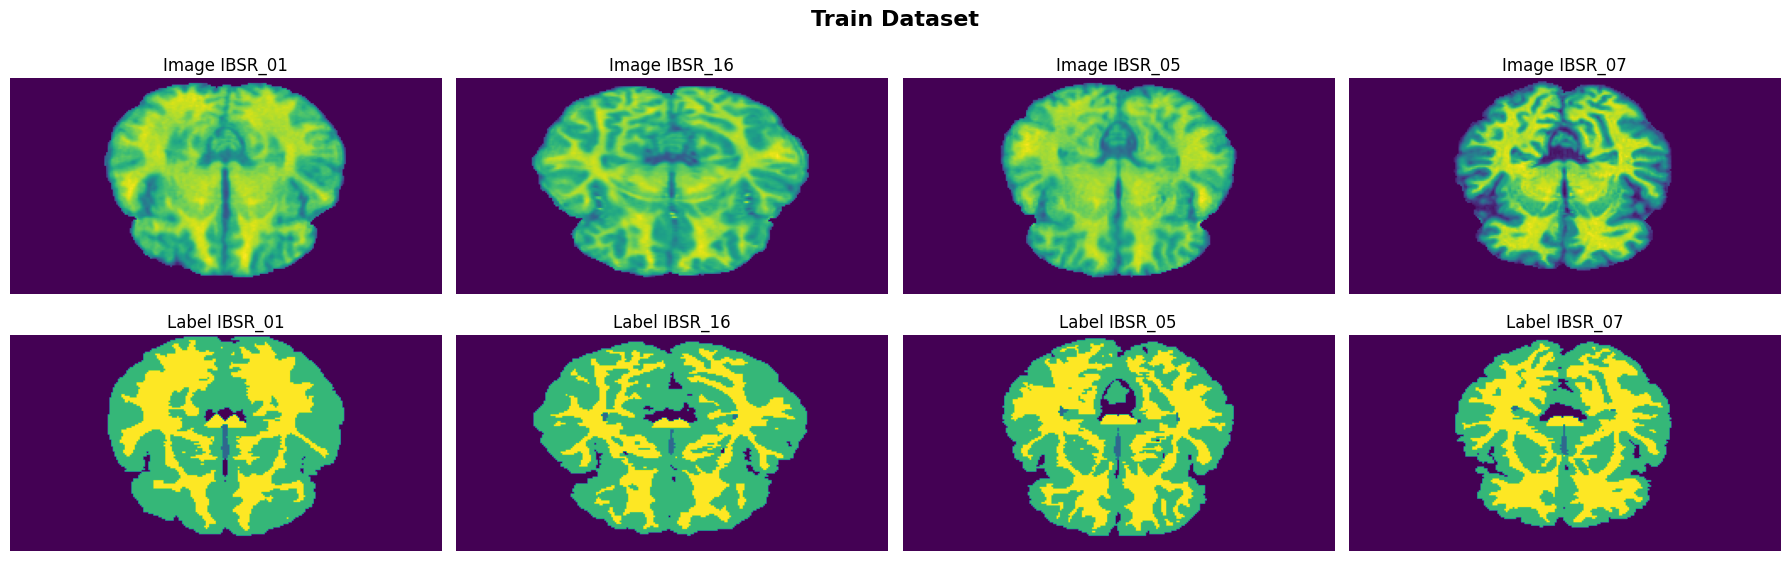

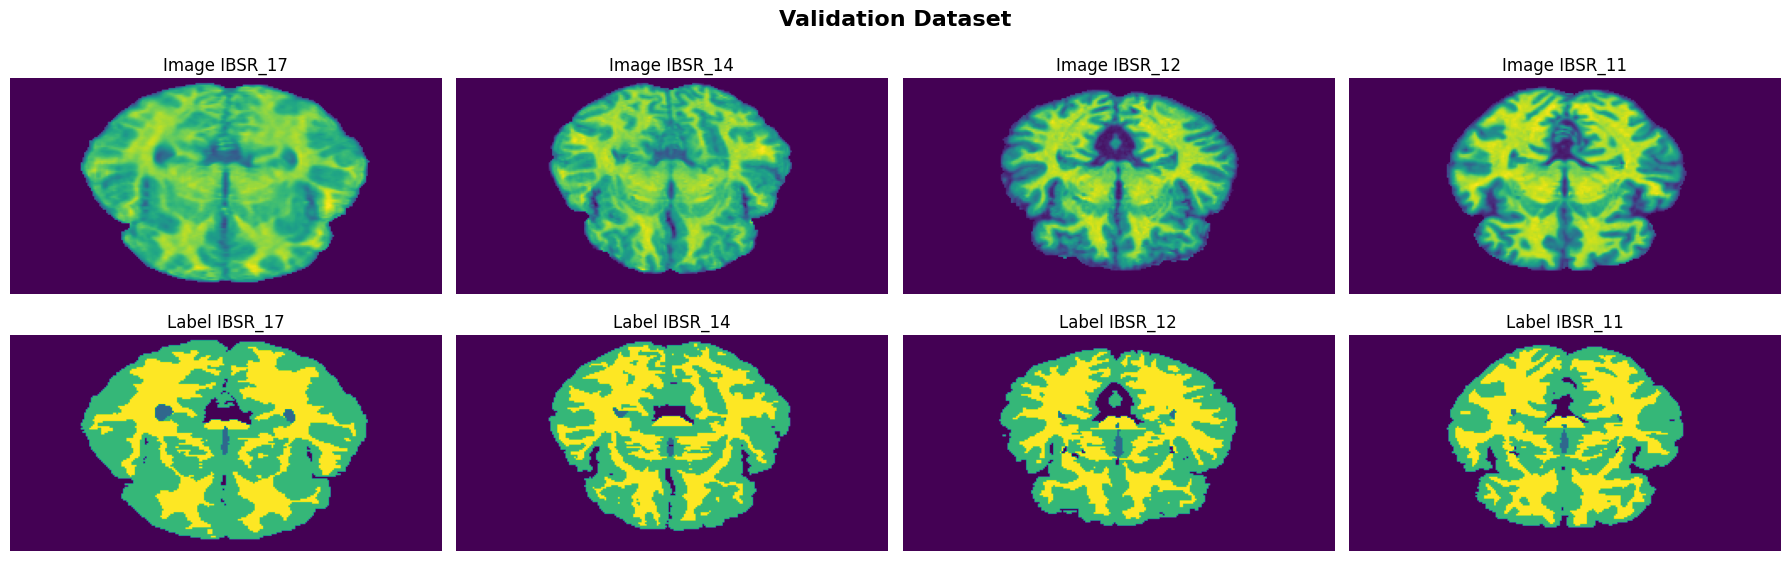

In [4]:
# Define a function to display images and their corresponding labels
def plot_images_and_labels(images, labels, image_names, num_samples=4, dataset='Training Images'):
    """
    Plot images and their corresponding labels.

    Args:
    - images      : Array of images 
    - labels      : Array of labels 
    - image_names : List of image names or identifiers
    - num_samples : Number of samples to plot
    - dataset     : Type of Dataset
    """
    
    # Set the figure size
    plt.figure(figsize=(18, 6))
    
    # Define the slice number
    slice_num = 125

    # Select random indices for samples to plot
    random_indices = random.sample(range(len(images)), num_samples)

    # Iterate through the selected random indices
    for i, idx in enumerate(random_indices, 1):
        # Plot the image
        plt.subplot(2, num_samples, i)
        plt.imshow(images[idx, slice_num, :, :], cmap='viridis')  
        plt.title(f"Image {image_names[idx]}")  
        plt.axis('off')  

        # Plot the label
        plt.subplot(2, num_samples, i + num_samples)
        plt.imshow(labels[idx, slice_num, :, :], cmap='viridis')  
        plt.title(f"Label {image_names[idx]}")  
        plt.axis('off')  

    # Set a super title for the entire plot
    plt.suptitle(dataset, fontsize=16, fontweight='bold')
    plt.tight_layout()  
    plt.show()  


# Plot train images and corresponding labels
train_image_names = os.listdir(TRAIN_DATA_PATH)
plot_images_and_labels(train_images, train_labels, train_image_names, dataset='Train Dataset')

# Plot validation images and corresponding labels
valid_image_names = os.listdir(VALID_DATA_PATH)
plot_images_and_labels(valid_images, valid_labels, valid_image_names, dataset='Validation Dataset')

# Data Pre-processing
- **Split train dataset into training and training-validation for training deep learning model.**

In [5]:
# Split train dataset into training and validation with a ration of (80:20)
training_images   = train_images[:8]
training_labels   = train_labels[:8]

validation_images = train_images[-2:]
validation_labels = train_labels[-2:]

print('Total Number of Training Images            :', len(training_images))
print('Total Number of Training-Validation Images :', len(validation_images))

Total Number of Training Images            : 8
Total Number of Training-Validation Images : 2


- **Extract patches from both the training and traininng-validation images and their corresponding labels.**

In [6]:
# Define required parameters for patch extraction
IMAGE_SIZE        = (256, 128, 256)  
PATCH_SIZE        = (32, 32)         
PATCH_STRIDE      = (32, 32)         
BATCH_SIZE        = 64              
N_CLASSES         = 4                
N_INPUT_CHANNELS  = 1                
CONTENT_THRESHOLD = 0.3    

# Define a function to extract patches from images and labels
def extract_patches(images, 
                    labels, 
                    image_size  = IMAGE_SIZE, 
                    patch_size  = PATCH_SIZE, 
                    stride      = PATCH_STRIDE, 
                    threshold   = CONTENT_THRESHOLD, 
                    num_classes = N_CLASSES):
    
    """
    Extracts patches from input images and labels.

    Args:
    - images     : Input images.
    - labels     : Corresponding labels for the input images.
    - image_size : Dimensions of the input images (slice, height, width).
    - patch_size : Dimensions of the patches to be extracted (height, width).
    - stride     : Dimensions of the stride for patch extraction (vertical stride, horizontal stride).
    - threshold  : Threshold value to determine the usefulness of extracted patches.
    - num_classes: Number of classes in the dataset.

    Returns:
    - useful_image_patches: Extracted patches from input images.
    - useful_label_patches: Extracted patches from labels of the corresponding input images.
    """

    # Reshape images and labels for patch extraction
    images_reshaped = images.reshape([-1, image_size[1], image_size[2], 1])
    labels_reshaped = labels.reshape([-1, image_size[1], image_size[2], 1])

    # Extract patches from images
    image_patches = tf.image.extract_patches(
        images_reshaped,
        sizes   = [1, patch_size[0], patch_size[1], 1],
        strides = [1, stride[0], stride[1], 1],
        rates   = [1, 1, 1, 1],
        padding = 'SAME'
    ).numpy()

    # Extract patches from labels
    label_patches = tf.image.extract_patches(
        labels_reshaped,
        sizes   = [1, patch_size[0], patch_size[1], 1],
        strides = [1, stride[0], stride[1], 1],
        rates   = [1, 1, 1, 1],
        padding = 'SAME'
    ).numpy()

    # Reshape patches for further processing
    image_patches = image_patches.reshape([-1, *patch_size, 1])
    label_patches = label_patches.reshape([-1, *patch_size])

    # Masking to retain only foreground patches
    foreground_mask = label_patches != 0
    patch_product   = np.prod(patch_size)

    # Check for useful patches based on the threshold
    useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * patch_product

    # Filter patches based on usefulness
    useful_image_patches = image_patches[useful_patches]
    useful_label_patches = label_patches[useful_patches]

    # Convert label patches to one-hot encoded format
    useful_label_patches = tf.keras.utils.to_categorical(useful_label_patches, num_classes=num_classes, dtype='float32')

    return useful_image_patches, useful_label_patches

# Extract patches from training and validation images along with their corresponding labels
(training_image_patches, training_label_patches)     = extract_patches(training_images, training_labels)
(validation_image_patches, validation_label_patches) = extract_patches(validation_images, validation_labels)

print('Total Number of Patches from Training Images   : ', len(training_image_patches))
print('Total Number of Patches from Validation Images : ', len(validation_image_patches))

2024-01-12 20:25:09.249214: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Total Number of Patches from Training Images   :  9893
Total Number of Patches from Validation Images :  2895


- **Display some random patches for the vizualization.**

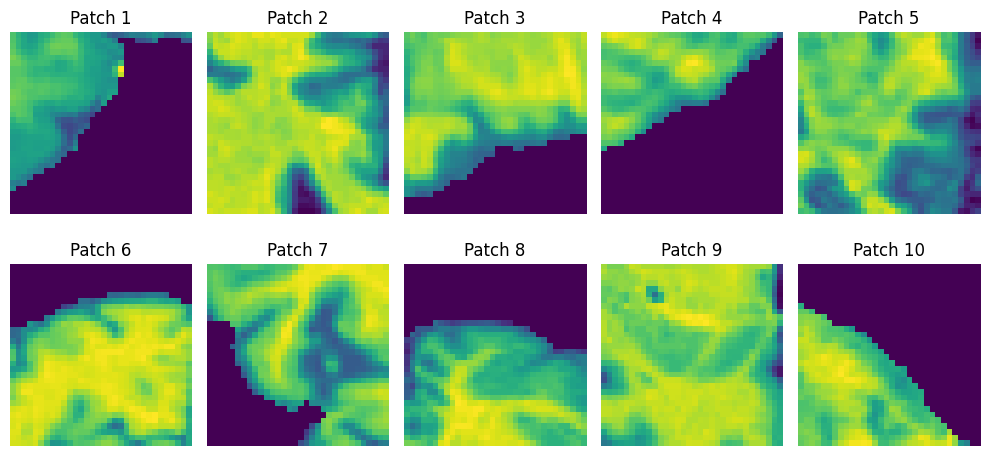

In [7]:
# Define the number of patches to plot
num_patches = 10

# Randomly select patches to plot
random_indices = np.random.choice(len(training_image_patches), num_patches, replace=False)

# Create a figure to plot the patches
plt.figure(figsize=(10, 5))

# Loop through each patch to plot
for i in range(num_patches):
    plt.subplot(2, 5, i + 1)  
    patch_index   = random_indices[i]  
    patch_to_plot = training_image_patches[patch_index]  
    plt.imshow(patch_to_plot, cmap='viridis')  
    plt.axis('off')  
    plt.title(f'Patch {i+1}')  

plt.tight_layout()  
plt.show()  

# Data Augmentation
- **Augment the training and training-validation dataset to handle data imbalance.**

In [8]:
# Degree of Augmentation
DEGREE = 0.2

# Create the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range     = 40,            
    width_shift_range  = DEGREE,    
    height_shift_range = DEGREE,                
    shear_range        = DEGREE,          
    zoom_range         = DEGREE,            
    horizontal_flip    = True,        
    vertical_flip      = True,           
    fill_mode          ='nearest'  # fill_mode options: 'constant', 'nearest', 'reflect', 'wrap'
   
)

# Generate augmented training data and labels 
train_generator = datagen.flow(
    training_image_patches,
    batch_size=int(training_image_patches.shape[0] / BATCH_SIZE),  
    seed=1  
)

train_label_generator = datagen.flow(
    training_label_patches,
    batch_size=int(training_label_patches.shape[0] / BATCH_SIZE),  
    seed=1  
)

# Generate augmented training-validation data and labels 
validation_generator = datagen.flow(
    validation_image_patches,
    batch_size=int(validation_image_patches.shape[0] / BATCH_SIZE),  
    seed=1 
)

validation_label_generator = datagen.flow(
    validation_label_patches,
    batch_size=int(validation_label_patches.shape[0] / BATCH_SIZE),  
    seed=1  
)

In [9]:
# Retrieve batches of augmented data from the generators
X_train = train_generator.next()  
Y_train = train_label_generator.next()  

# Concatenate original and augmented data for the training set
total_train_images = np.concatenate((training_image_patches, X_train))
total_train_labels = np.concatenate((training_label_patches, Y_train))

# Retrieve batches of augmented data for the validation set
X_validation = validation_generator.next()  
Y_validation = validation_label_generator.next()  

# Concatenate original and augmented data for the validation set
total_validation_images = np.concatenate((validation_image_patches, X_validation))
total_validation_labels = np.concatenate((validation_label_patches, Y_validation))

# Display shapes of the datasets
print('---------Training Dataset----------')
print('Shape of Image Patches:', total_train_images.shape)
print('Shape of Label Patches:', total_train_labels.shape)

print('\n---------Validation Dataset----------')
print('Shape of Image Patches:', total_validation_images.shape)
print('Shape of Label Patches:', total_validation_labels.shape)


---------Training Dataset----------
Shape of Image Patches: (10047, 32, 32, 1)
Shape of Label Patches: (10047, 32, 32, 4)

---------Validation Dataset----------
Shape of Image Patches: (2940, 32, 32, 1)
Shape of Label Patches: (2940, 32, 32, 4)


In [11]:
# Convert grayscale training images into 3 channel images for the model training
total_train_images = np.array(total_train_images).reshape(10047, 32, 32)
total_train_images_rgb = np.stack((total_train_images,) * 3, axis=-1)

# Convert grayscale validation images into 3 channel images for the model training
total_validation_images = np.array(total_validation_images).reshape(2940, 32, 32)
total_validation_images_rgb = np.stack((total_validation_images,) * 3, axis=-1)


# Display shapes of the datasets
print('---------Dataset----------')
print('Shape of Training Image Patches  :', total_train_images_rgb.shape)
print('Shape of Validation Image Patches:', total_validation_images_rgb.shape)


---------Dataset----------
Shape of Training Image Patches  : (10047, 32, 32, 3)
Shape of Validation Image Patches: (2940, 32, 32, 3)


# ResNet34-LinkNet Model

In [12]:
# Define training parameters
N_EPOCHS      = 100
BATCH_SIZE    = 64
LEARNING_RATE = 0.001
PATIENCE      = 20
BACKBONE      = 'resnet34'
ACTIVATION    = 'softmax'
OPTIMIZER     = Adam(LEARNING_RATE)

# Define the loss 
dice_loss  = sm.losses.DiceLoss(class_weights=np.array([0.25,0.25,0.25,0.25]))
focal_loss = sm.losses.CategoricalCELoss()
LOSS       = dice_loss + (1*focal_loss)

# Define the performance metrics
metrics  = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Preprocess the data according to the training backbone
preprocess_input = sm.get_preprocessing(BACKBONE)

# Apply the preprocessed on the training and validation data
total_train_images_preprocessed      = preprocess_input(total_train_images_rgb)
total_validation_images_preprocessed = preprocess_input(total_validation_images_rgb)

# Define the ResNet50-UNet model
resnet34_linknet_model = sm.Linknet(BACKBONE, encoder_weights='imagenet', classes=N_CLASSES, activation='softmax')

# Compline the model
resnet34_linknet_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=metrics)

# Print the model summary
print(resnet34_linknet_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

- **Train ResNet34-LinkNet Model**

In [13]:
# Train the ResNet50-UNet Model
history = resnet34_linknet_model.fit(total_train_images_preprocessed,
                            total_train_labels,
                            batch_size = BATCH_SIZE,
                            epochs     = N_EPOCHS,
                            verbose    = 1,
                            validation_data= (total_validation_images_preprocessed, total_validation_labels)
                               )

Epoch 1/100
157/157 [==============================] - 63s 270ms/step - loss: 0.9636 - iou_score: 0.5409 - f1-score: 0.6215 - val_loss: 1.3818 - val_iou_score: 0.1956 - val_f1-score: 0.2713
Epoch 2/100
157/157 [==============================] - 38s 241ms/step - loss: 0.8524 - iou_score: 0.7939 - f1-score: 0.8826 - val_loss: 1.4822 - val_iou_score: 0.1898 - val_f1-score: 0.2415
Epoch 3/100
157/157 [==============================] - 40s 254ms/step - loss: 0.8431 - iou_score: 0.8092 - f1-score: 0.8923 - val_loss: 1.7260 - val_iou_score: 0.2074 - val_f1-score: 0.2730
Epoch 4/100
157/157 [==============================] - 40s 253ms/step - loss: 0.8353 - iou_score: 0.8268 - f1-score: 0.9039 - val_loss: 1.8108 - val_iou_score: 0.1803 - val_f1-score: 0.2219
Epoch 5/100
157/157 [==============================] - 49s 312ms/step - loss: 0.8300 - iou_score: 0.8375 - f1-score: 0.9105 - val_loss: 1.6056 - val_iou_score: 0.1615 - val_f1-score: 0.2056
Epoch 6/100
157/157 [=============================

- **Save the ResNet34-LinkNet trained model**

In [14]:
# Save the model after training
model_name = 'resnet34_linknet.keras'
resnet34_linknet_model.save(str(MODEL_SAVE_PATH / model_name))
print("Model saved successfully.")

Model saved successfully.


- **Plot the Training and Validation Loss, IOU Score, F1 Score**

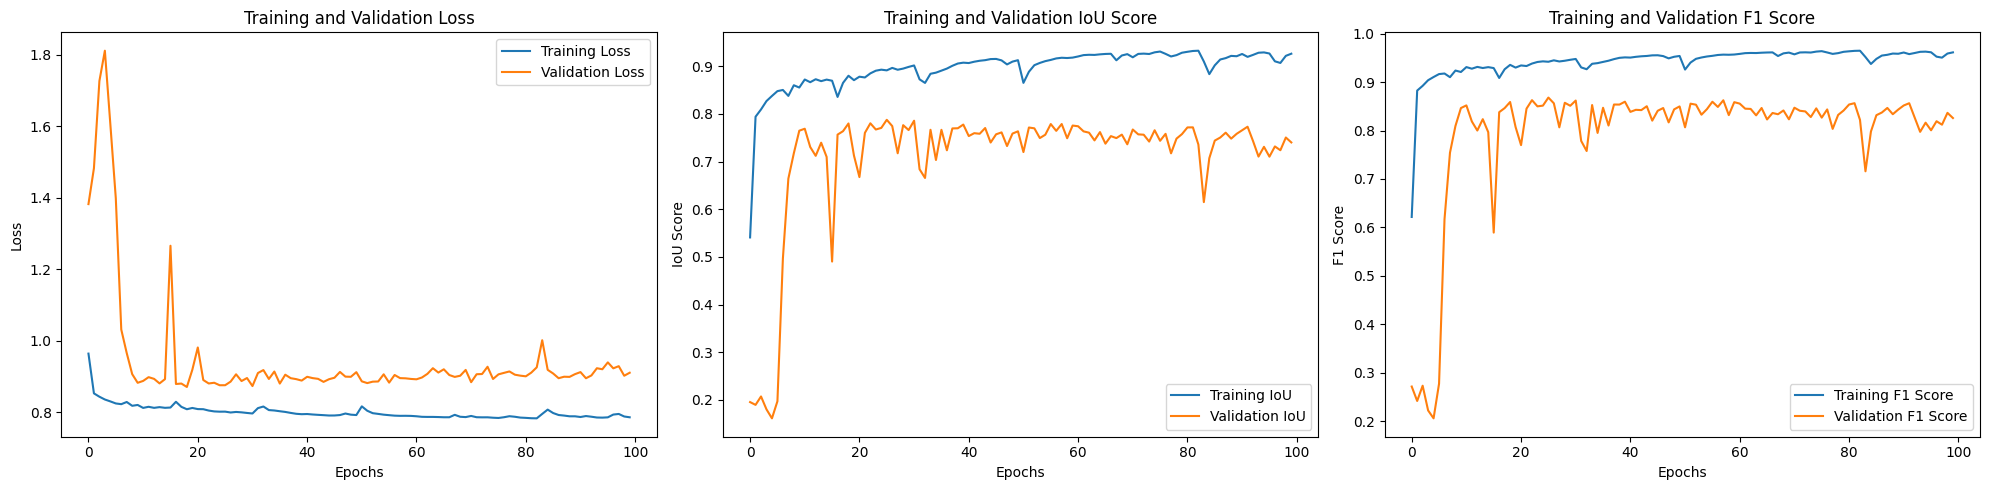

In [15]:
# Accessing metrics from the history object
training_loss   = history.history['loss']
validation_loss = history.history['val_loss']
training_iou    = history.history['iou_score']
validation_iou  = history.history['val_iou_score']
training_f1     = history.history['f1-score']
validation_f1   = history.history['val_f1-score']

# Creating subplots in a 1x3 grid
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plotting Loss
axs[0].plot(training_loss, label='Training Loss')
axs[0].plot(validation_loss, label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting IOU Score
axs[1].plot(training_iou, label='Training IoU')
axs[1].plot(validation_iou, label='Validation IoU')
axs[1].set_title('Training and Validation IoU Score')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('IoU Score')
axs[1].legend()

# Plotting F1 Score
axs[2].plot(training_f1, label='Training F1 Score')
axs[2].plot(validation_f1, label='Validation F1 Score')
axs[2].set_title('Training and Validation F1 Score')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('F1 Score')
axs[2].legend()

plt.tight_layout()
plt.show()

# Test Prediction
- **Prepare the validation that for making the prediction using the trained models.**

In [16]:
# Define a function to prepare validation data for prediction using the trained model
def prepare_valid_data(valid_images, valid_labels):
    """
    Prepare validation data for prediction by reshaping images and labels.

    Args:
    - valid_images : Validation images data.
    - valid_labels : Validation labels data.

    Returns:
    - valid_images_reshaped: Reshaped validation images.
    - valid_labels_modified: Modified validation labels.
    """
    
    # Reshape the valid images and labels to match the required input shape for the model
    valid_images_reshaped = valid_images.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
    
    # Modify the validation labels to categorical format suitable for model prediction
    valid_labels_modified = np.squeeze(valid_labels, axis=-1)
    
    return valid_images_reshaped, valid_labels_modified


- **Predict the validation dataset using trained ResNet50-UNet Model.**

In [17]:
# Define lists to store processed validation labels and validation predictions 
valid_processed_labels = []  
valid_predictions      = []       

# Iterate through each validation image and label
for i in range(len(valid_images)):
    
    # Prepare the individual validation image and label for the prediction using trained model
    pre_valid_image, pre_valid_label = prepare_valid_data(valid_images[i], valid_labels[i])

    # Convert grayscale validation images into 3 channel images for the model training
    pre_valid_image = np.array(pre_valid_image).reshape(256, 128, 256)
    pre_valid_image_rgb = np.stack((pre_valid_image,) * 3, axis=-1)

    # Get predictions using the trained ResNet34-LinkNet model for the prepared validation image
    prediction = resnet34_linknet_model.predict(x=pre_valid_image_rgb)
    
    # Transform the prediction to obtain the predicted class indices
    prediction = np.argmax(prediction, axis=3)
    
    # Append the predicted labels and processed validation labels to their respective lists
    valid_predictions.append(prediction)
    valid_processed_labels.append(pre_valid_label)


8/8 [==============================] - 2s 206ms/step


In [18]:
print('Shape of the predictions: ',valid_predictions[1].shape)
print('Shape of the labels     : ',valid_processed_labels[1].shape)

Shape of the predictions:  (256, 128, 256)
Shape of the labels     :  (256, 128, 256)


- **Display some random segmentation results with their corresponding groundtruth.**

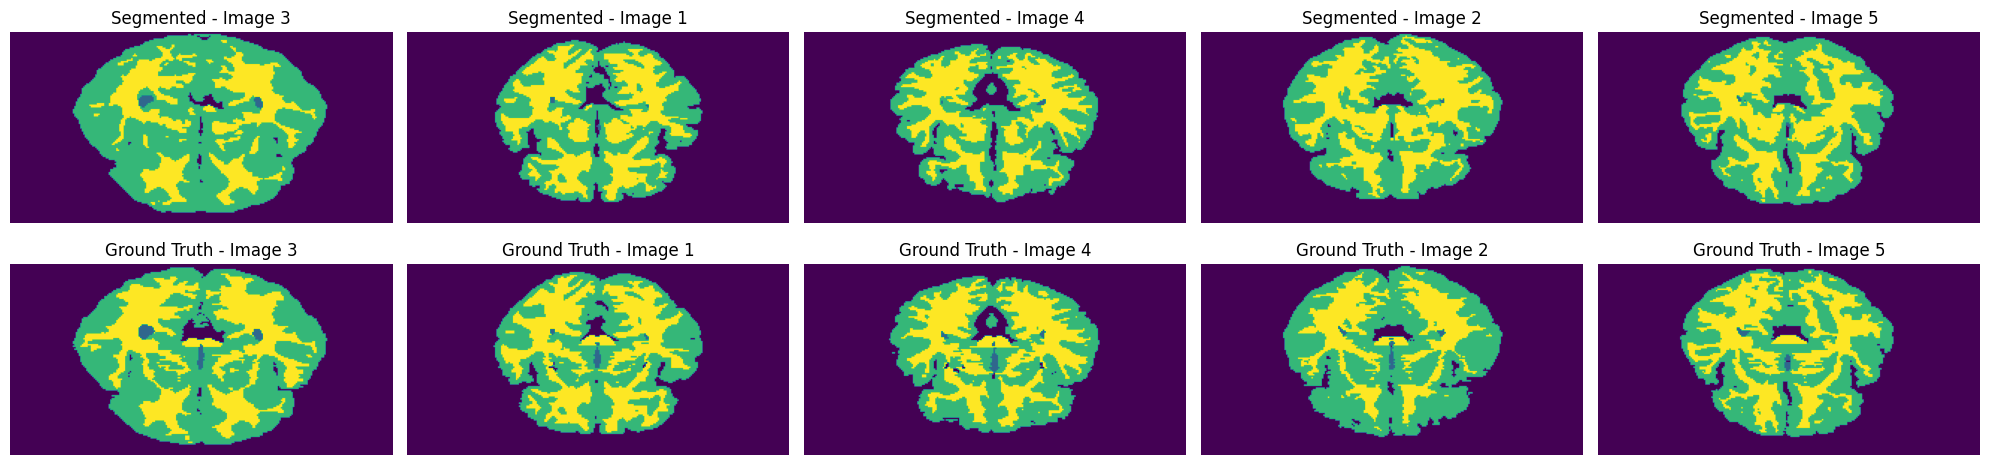

In [19]:
# Select 5 random indices for images to plot
indices = random.sample(range(len(valid_processed_labels)), 5)

# Plot the images
plt.figure(figsize=(20, 5))

for i, index in enumerate(indices, 1):
    
    # Plot segmented images
    plt.subplot(2, 5, i)
    plt.imshow(valid_predictions[index][125,:,:], cmap='viridis')  
    plt.title(f'Segmented - Image {index + 1}')
    plt.axis('off')
    
    # Plot groundtruth 
    plt.subplot(2, 5, i + 5)
    plt.imshow(valid_labels[index][125,:,:], cmap='viridis')  
    plt.title(f'Ground Truth - Image {index + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Performance Evaluation
- **Define functions for computing Dice Scores (DSC), Housdroff Distances (HD), Absolute Volume Differences (AVD)**

In [20]:
def compute_dice_score(groundtruth_image, segmented_image):
    """
    Compute the Dice score for image segmentation.

    The Dice score is a measure of overlap between two samples. This function calculates the score for each label 
    in the images and returns a dictionary of scores for each label.

    Parameters:
    groundtruth_image (np.ndarray): The ground truth image.
    segmented_image (np.ndarray): The image produced by segmentation algorithm.

    Returns:
    dict: Dice scores for each label.
    """
    labels = [0, 1, 2, 3]  # Labels represent different segments like Background, CSF, GM, and WM
    scores = {}

    for label in labels:
        # Create binary arrays for the current label
        gt = groundtruth_image == label
        seg = segmented_image == label

        # Calculate intersection and the sum of elements in both images
        intersection = np.sum(gt & seg)
        size_gt = np.sum(gt)
        size_seg = np.sum(seg)

        # Compute Dice score
        if size_gt + size_seg == 0:
            scores[label] = 1  # Handle division by zero
        else:
            scores[label] = 2.0 * intersection / (size_gt + size_seg)

    return scores


def compute_hausdorff_distance(ground_truth, segmentation):
    """
    Calculate the Hausdorff Distance for 3D image segmentation.

    The Hausdorff Distance is a measure of the extent to which two subsets of a metric space are close to each other.
    This function calculates the distance for each label in 3D binary images, including the background.

    Parameters:
    ground_truth (np.ndarray): Ground truth 3D binary image.
    segmentation (np.ndarray): Segmented 3D binary image.

    Returns:
    dict: Hausdorff Distances for each label.
    """
    labels = np.unique(ground_truth)  # Extract all unique labels from the ground truth
    distances = {}

    for label in labels:
        max_hd = 0
        # Iterate over each slice of the 3D image
        for slice_idx in range(ground_truth.shape[0]):
            # Create binary slices for the current label
            seg1_slice = (ground_truth[slice_idx] == label).astype(int)
            seg2_slice = (segmentation[slice_idx] == label).astype(int)

            # Calculate Hausdorff distance if label is present in the slice
            if np.any(seg1_slice) and np.any(seg2_slice):
                hd1 = directed_hausdorff(seg1_slice, seg2_slice)[0]
                hd2 = directed_hausdorff(seg2_slice, seg1_slice)[0]
                max_hd = max(max_hd, max(hd1, hd2))

        distances[f'Label_{label}'] = max_hd

    return distances



def compute_volumetric_difference(groundtruth_image, segmented_image):
    """
    Compute the Volumetric Difference for image segmentation.

    This function calculates the absolute volumetric difference (AVD) for each label between the segmented image 
    and the ground truth. AVD is a measure of the difference in volume for a given label.

    Parameters:
    groundtruth_image (np.ndarray): The ground truth image.
    segmented_image (np.ndarray): The image produced by segmentation algorithm.

    Returns:
    dict: Volumetric difference scores for each label.
    """
    groundtruth_image = np.array(groundtruth_image)
    segmented_image   = np.array(segmented_image)

    # Ensure that both images have the same shape
    if groundtruth_image.shape != segmented_image.shape:
        raise ValueError("Segmented and ground truth images must have the same shape")

    avd_scores = {}
    for label in [0, 1, 2, 3]:  # Labels for Background, CSF, GM, WM
        # Compute volumes for each label in both images
        segmented_volume = np.sum(segmented_image == label)
        groundtruth_volume = np.sum(groundtruth_image == label)

        # Calculate the Absolute Volumetric Difference
        if groundtruth_volume > 0:
            avd_score = abs(segmented_volume - groundtruth_volume) / groundtruth_volume * 100
        else:
            avd_score = 0

        avd_scores[label] = avd_score

    return avd_scores


- **Compute the Dice Score (DSC)**

In [21]:
# Define list to store Dice coefficients for each image
dice_scores = []  
image_id = ['IBSR_11', 'IBSR_12', 'IBSR_13', 'IBSR_14', 'IBSR_17']

# Iterate over segemented images to compute dice score
for i in range(len(valid_predictions)): 
    
    # Calculate Dice coefficients for each class between predicted and ground truth images
    scores = compute_dice_score(valid_predictions[i], valid_processed_labels[i])
    scores['ImageID'] = image_id[i]
    dice_scores.append(scores)

# Convert the list of Dice scores to a pandas DataFrame
df_dice_scores = pd.DataFrame(dice_scores)
df_dice_scores = df_dice_scores.set_index('ImageID')
df_dice_scores.columns = ['Background', 'CSF', 'GM', 'WM']

# Calculate mean and standard deviation for each class
mean_scores = df_dice_scores.mean()
std_dev_scores = df_dice_scores.std()

# Calculate the average of the mean and standard deviation
avg_mean = mean_scores.mean()
avg_std_dev = std_dev_scores.mean()

# Display the DataFrame with mean and standard deviation
print("Dice Scores:")
print(df_dice_scores)
print("\nMean (DSC):")
print(mean_scores)
print("\nStandard Deviation (DSC):")
print(std_dev_scores)
print(f"\nAverage of Mean (DSC)     : {avg_mean}")
print(f"Average of Std. Dev. (DSC): {avg_std_dev}")

Dice Scores:
         Background       CSF        GM        WM
ImageID                                          
IBSR_11    0.996887  0.750896  0.896474  0.913144
IBSR_12    0.996455  0.754748  0.863464  0.801039
IBSR_13    0.996122  0.847571  0.904008  0.806190
IBSR_14    0.995854  0.785385  0.888168  0.892042
IBSR_17    0.997532  0.845423  0.918422  0.900365

Mean (DSC):
Background    0.996570
CSF           0.796805
GM            0.894107
WM            0.862556
dtype: float64

Standard Deviation (DSC):
Background    0.000662
CSF           0.047296
GM            0.020428
WM            0.054359
dtype: float64

Average of Mean (DSC)     : 0.8875094913523209
Average of Std. Dev. (DSC): 0.030686155097681404


- **Compute the Housdroff Distances (HD)**

In [22]:
# Define list to store Hausdorff Distance for each image
hd_scores = []  
image_id = ['IBSR_11', 'IBSR_12', 'IBSR_13', 'IBSR_14', 'IBSR_17']

# Iterate over segemented images to compute dice score
for i in range(len(valid_predictions)): 
    
    # Calculate Dice coefficients for each class between predicted and ground truth images
    hd = compute_hausdorff_distance(valid_predictions[i], valid_processed_labels[i])
    hd['ImageID'] = image_id[i]
    hd_scores.append(hd)

# Convert the list of Hausdorff distances to a pandas DataFrame
df_hd_scores = pd.DataFrame(hd_scores)
df_hd_scores = df_hd_scores.set_index('ImageID')
df_hd_scores.columns = ['Background', 'CSF', 'GM', 'WM']

# Display the DataFrame
print("Hausdorff Distances:")
print(df_hd_scores)

# Calculate mean and standard deviation for each class
mean_scores    = df_hd_scores.mean()
std_dev_scores = df_hd_scores.std()

# Calculate the average of the mean and standard deviation
avg_mean       = mean_scores.mean()
avg_std_dev    = std_dev_scores.mean()

# Display the DataFrame with mean and standard deviation
print("\nMean (HD):")
print(mean_scores)
print("\nStandard Deviation (HD):")
print(std_dev_scores)

print(f"\nAverage of Mean (HD)     : {avg_mean}")
print(f"Average of Std. Dev. (HD): {avg_std_dev}")

Hausdorff Distances:
         Background       CSF        GM        WM
ImageID                                          
IBSR_11    5.830952  4.123106  7.483315  6.324555
IBSR_12    6.633250  4.242641  7.280110  6.782330
IBSR_13    6.403124  3.872983  8.000000  7.211103
IBSR_14    6.164414  4.123106  6.782330  6.557439
IBSR_17    5.567764  3.741657  6.855655  6.403124

Mean (HD):
Background    6.119901
CSF           4.020699
GM            7.280282
WM            6.655710
dtype: float64

Standard Deviation (HD):
Background    0.428389
CSF           0.206105
GM            0.496860
WM            0.356235
dtype: float64

Average of Mean (HD)     : 6.019147830630174
Average of Std. Dev. (HD): 0.3718973881631924


- **Compute the Absolute Volumn Differences (AVD)**

In [23]:
# Define list to store Hausdorff Distance for each image
avd_scores = []  
image_id = ['IBSR_11', 'IBSR_12', 'IBSR_13', 'IBSR_14', 'IBSR_17']

# Iterate over segemented images to compute dice score
for i in range(len(valid_predictions)): 
    
    # Calculate Dice coefficients for each class between predicted and ground truth images
    volumn_difference = compute_volumetric_difference(valid_predictions[i], valid_processed_labels[i])
    
    # Append the image ID to the scores for identification
    volumn_difference['ImageID'] = image_id[i]
    avd_scores.append(volumn_difference)

# Convert the list of AVD scores to a pandas DataFrame and set index to ImageID
df_avd_scores = pd.DataFrame(avd_scores)
df_avd_scores = df_avd_scores.set_index('ImageID')
df_avd_scores.columns = ['Background', 'CSF', 'GM', 'WM']

print("Average Volumetric Difference:")
print(df_avd_scores)

# Calculate mean and standard deviation for each label
mean_scores = df_avd_scores.mean()
std_dev_scores = df_avd_scores.std()

# Calculate the overall average of the mean and standard deviation
avg_mean = mean_scores.mean()
avg_std_dev = std_dev_scores.mean()

# Display the DataFrame with mean and standard deviation
print("\nMean (AVD) :")
print(mean_scores)
print("\nStandard Deviation (AVD):")
print(std_dev_scores)

print(f"\nAverage of Mean (AVD)     : {avg_mean}")
print(f"Average of Std. Dev. (AVD): {avg_std_dev}")

Average Volumetric Difference:
         Background        CSF         GM         WM
ImageID                                             
IBSR_11    0.380206  18.367122   6.219669   1.055629
IBSR_12    0.000679  54.051039  16.434819  27.395594
IBSR_13    0.203802  27.164790  12.509299  36.976927
IBSR_14    0.574932  24.178884   7.085283   1.249368
IBSR_17    0.153568  21.641071   3.215752   8.705672

Mean (AVD) :
Background     0.262637
CSF           29.080581
GM             9.092964
WM            15.076638
dtype: float64

Standard Deviation (AVD):
Background     0.220981
CSF           14.329560
GM             5.301000
WM            16.276906
dtype: float64

Average of Mean (AVD)     : 13.378205237625098
Average of Std. Dev. (AVD): 9.032111723408597


- **Show statistical analysis for each class.**

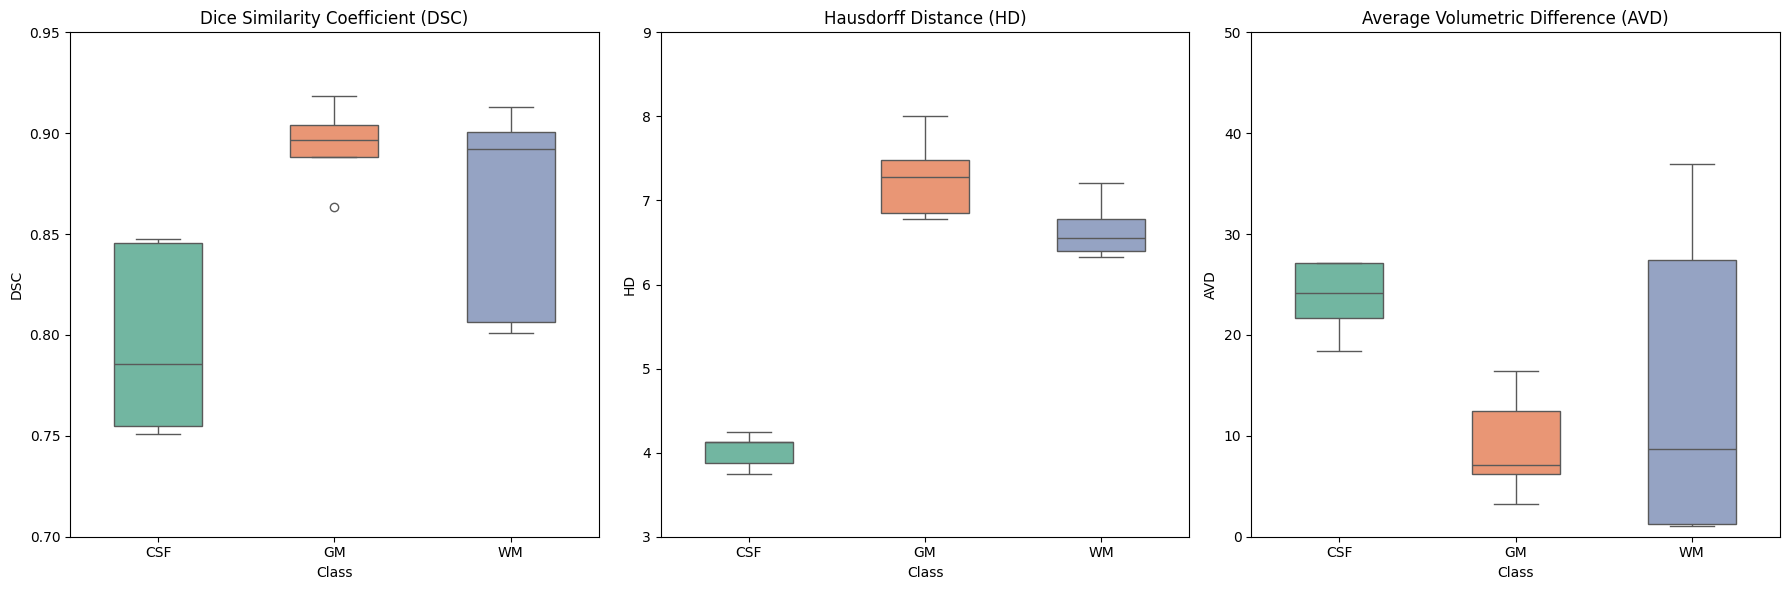

In [27]:
# Reshape the data into a long format
df_dice_long = df_dice_scores.melt(var_name='Class', value_name='DSC')
df_hd_long   = df_hd_scores.melt(var_name='Class', value_name='HD')
df_avd_long  = df_avd_scores.melt(var_name='Class', value_name='AVD')

# Combine the data into a single DataFrame
combined_data = pd.concat([df_dice_long, df_hd_long, df_avd_long], keys=['DSC', 'HD', 'AVD'])

# Correcting the DataFrame structure for combined data
combined_data = combined_data.reset_index(level=0).reset_index(drop=True)
combined_data.rename(columns={'level_0': 'Metric'}, inplace=True)

# Remove the 'Background' class from the DataFrame
combined_data = combined_data[combined_data['Class'] != 'Background']

# Number of unique classes
num_classes = combined_data['Class'].nunique()

# Define a color palette with the exact number of unique classes
palette = sns.color_palette("Set2", n_colors=num_classes)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# DSC Plot
sns.boxplot(ax=axes[0], x='Class', y='DSC', hue='Class', data=combined_data[combined_data['Metric'] == 'DSC'], width=0.5, palette=palette)
axes[0].set_title('Dice Similarity Coefficient (DSC)')
axes[0].set_ylim([0.7, 0.95])  

# HD Plot
sns.boxplot(ax=axes[1], x='Class', y='HD', hue='Class', data=combined_data[combined_data['Metric'] == 'HD'], width=0.5, palette=palette)
axes[1].set_title('Hausdorff Distance (HD)')
axes[1].set_ylim([3, 9])  

# AVD Plot
sns.boxplot(ax=axes[2], x='Class', y='AVD', hue='Class', data=combined_data[combined_data['Metric'] == 'AVD'], width=0.5, palette=palette)
axes[2].set_title('Average Volumetric Difference (AVD)')
axes[2].set_ylim([0, 50])  

# Remove the legends
for ax in axes:
    ax.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

# Result Summary
- **Show the result of each trail attempted.**

In [6]:
# Define a fucntion to generate table for showing trail details
def generate_trial_details(trail_number, model_name, dice_scores, houssfield_distances, avd):
    trial_details = [
        ["Trial", f"Trail - {trail_number}", "", "", "", ""],
        ["Model", model_name, "", "", "", ""],
        ["Parameters", "Epochs = 30; Batch Size = 60; LR = 0.0001; Optimizer = Adam", "", "", "", ""],
        ["Dataset", "Validation Dataset", "", "", ""],
        ["Class", "", "Background", "CSF", "GM", "WM"],
        ["Dice Score (Mean)"] + [""] + [dice_scores['Background']] + [dice_scores[key] for key in ['CSF', 'GM', 'WM']],
        ["Houssfield Distance (Mean)"] + [""] + [houssfield_distances[key] for key in ['Background', 'CSF', 'GM', 'WM']],
        ["AVD (Mean)"] + [""] + [avd[key] for key in ['Background', 'CSF', 'GM', 'WM']],
    ]
    return trial_details

# Data for trail 1
trials_1 = [
    {
        'model_name': "ResNet36-UNet",
        'dice_scores': {
            'Background': 0.997,
            'CSF': 0.822,
            'GM': 0.902,
            'WM': 0.872
        },
        'houssfield_distances': {
            'Background': 15.99,
            'CSF': 26.11,
            'GM': 19.62,
            'WM': 11.15
        },
        'avd': {
            'Background': 14535,
            'CSF': 2246,
            'GM': 53023,
            'WM': 43089
        }
    }
]

# Data for trail 2
trials_2 = [
    {
        'model_name': "ResNet50-UNet",
        'dice_scores': {
            'Background': 0.993,
            'CSF': 0.622,
            'GM': 0.845,
            'WM': 0.764
        },
        'houssfield_distances': {
            'Background': 22.88,
            'CSF': 33.31,
            'GM': 14.11,
            'WM': 11.55
        },
        'avd': {
            'Background': 53724,
            'CSF': 7577,
            'GM': 68173,
            'WM': 106045
        }
    }
]

# Generate and print tables for trials in trials_1 list
for i, trial in enumerate(trials_1, start=1):
    trial_details = generate_trial_details(
        i, trial['model_name'], trial['dice_scores'], trial['houssfield_distances'], trial['avd']
    )
    print(f"Trail {i} Details:")
    print(tabulate(trial_details, headers="firstrow", tablefmt="pretty"))
    print("\n")

# Generate and print tables for trials in trials_2 list
for i, trial in enumerate(trials_2, start=1):
    trial_details = generate_trial_details(
        i+1, trial['model_name'], trial['dice_scores'], trial['houssfield_distances'], trial['avd']
    )
    print(f"Trail {i+1} Details:")
    print(tabulate(trial_details, headers="firstrow", tablefmt="pretty"))
    print("\n")


Trail 1 Details:
+----------------------------+-------------------------------------------------------------+------------+-------+-------+-------+
|           Trial            |                          Trail - 1                          |            |       |       |       |
+----------------------------+-------------------------------------------------------------+------------+-------+-------+-------+
|           Model            |                        ResNet36-UNet                        |            |       |       |       |
|         Parameters         | Epochs = 30; Batch Size = 60; LR = 0.0001; Optimizer = Adam |            |       |       |       |
|          Dataset           |                     Validation Dataset                      |            |       |       |       |
|           Class            |                                                             | Background |  CSF  |  GM   |  WM   |
|     Dice Score (Mean)      |                                           

# References

- **UNet Model:** https://github.com/anwai98/Brain-Tissue-Seg
- **Segmentation Models:** https://segmentation-models.readthedocs.io/en/latest/index.html

**The End**